In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
from fastai.vision.all import *
import sklearn.metrics as skm
from tqdm.notebook import tqdm
import sklearn.feature_extraction.text
from transformers import (BertTokenizer, BertModel,AutoModel,
                          DistilBertTokenizer, DistilBertModel,AutoModelForSeq2SeqLM)

from shopee_utils import *
from train_utils import *

In [3]:
import debugpy
#debugpy.listen(5678)

In [28]:
BERT_MODEL_CLASS = AutoModel
BERT_TOKENIZER_CLASS = BertTokenizer
class CONF(ConfigClass):
    bert_path ='indobenchmark/indobert-base-p2'
    arcface_m = .5
    arcface_s = 30
    lr = 1e-2
    lr_mult = 100
    train_epochs = 8
    train_freeze_epochs = 2
    do_mixup = True
    droput_p = .25
    embs_dim = 768
    tokens_max_length = 50
    adam_mom=.9
    adam_sqr_mom=.99
    adam_eps=1e-5
    adam_wd=0.01
    use_argmargin=True
    arc_easymargin=False
    label_smooth=.1
    experiment_id=0
    def toDict(self):
        return {k:self.__getattribute__(k) for k in dir(self) if k[:2]!='__' and not inspect.isroutine(self.__getattribute__(k))}
    
    def __repr__(self):
        return str(self.toDict())
    
    def foo():
        return CONF()
config = CONF()

In [5]:
# PATH = Path('../input/shopee-product-matching')
# model_file  = '../input/resnet-model/bert814.pth'
# if not PATH.is_dir():
#     PATH = Path('/home/slex/data/shopee')
#     model_file ='models/bert814.pth'
#BERT_PATH = './bert_indonesian' #.823
#BERT_PATH='bert-base-multilingual-cased'
#BERT_PATH='bert-base-cased'
#BERT_PATH='cahya/distilbert-base-indonesian'
#BERT_PATH='indobenchmark/indobert-base-p1' #.815
#BERT_PATH='indobenchmark/indobert-base-p2'  #.817
#BERT_PATH='indobenchmark/indobert-large-p1' #.829
#BERT_PATH='indobenchmark/indobert-large-p2' #.828
#BERT_PATH='indobenchmark/indobert-lite-large-p2'#.768


# BertModelClass = AutoModel
# BertTokenizerClass = BertTokenizer

In [6]:
train_df = pd.read_csv(PATH/'train_split.csv')
train_df['is_valid'] = train_df.split==0

In [7]:
class ArcFaceClassifier(nn.Module):
    def __init__(self, in_features, output_classes):
        super().__init__()
        self.initial_layers=nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(config.droput_p))
        self.W = nn.Parameter(torch.Tensor(in_features, output_classes))
        nn.init.kaiming_uniform_(self.W)
    def forward(self, x):
        x = self.initial_layers(x)
        x_norm = F.normalize(x)
        W_norm = F.normalize(self.W, dim=0)
        return x_norm @ W_norm
    


In [8]:
class ArcMarginProductLoss():
    def __init__(self,out_features, scale=30.0, margin=0.50, easy_margin=False, ls_eps=0.0):
        self.scale = scale
        self.margin = margin
        self.ls_eps = ls_eps  # label smoothing
        self.out_features=out_features
        self.easy_margin = easy_margin
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin
    def __call__(self, cosine, label):
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
    
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.scale
        return F.cross_entropy(output, label)

In [9]:
class BertArcFace(nn.Module):
    def __init__(self, bert_model):
        super().__init__()
        self.bert_model = bert_model
        #self.classifier = ArcMarginProduct(config.embs_dim, dls.c)
        self.classifier = ArcFaceClassifier(config.embs_dim, dls.c)
        self.outputEmbs = False
    def forward(self, x):
        output = self.bert_model(*x)
        last_hidden =output.last_hidden_state[:,0,:]
        embeddings=last_hidden
        if self.outputEmbs:
            return embeddings
        return self.classifier(embeddings)


In [10]:
class TitleTransform(Transform):
    def __init__(self):
        super().__init__()
        self.tokenizer = BERT_TOKENIZER_CLASS.from_pretrained(config.bert_path)
        
        
    def encodes(self, row):
        text = row.title
        encodings = self.tokenizer(text, padding = 'max_length', max_length=config.tokens_max_length,
                                   truncation=True,return_tensors='pt')
        keys =['input_ids', 'attention_mask']#, 'token_type_ids'] 
        return tuple(encodings[key].squeeze() for key in keys)

In [11]:
tfm = TitleTransform()

data_block = DataBlock(
    blocks = (TransformBlock(type_tfms=tfm), 
              CategoryBlock(vocab=train_df.label_group.to_list())),
    splitter=ColSplitter(),
    get_y=ColReader('label_group'),
    )
dls = data_block.dataloaders(train_df, bs=128)


In [12]:
def new_model():
    bert_model = BERT_MODEL_CLASS.from_pretrained(config.bert_path)
    return BertArcFace(bert_model)

In [13]:
def split_2way(model):
    return L(params(model.bert_model),
            params(model.classifier))

In [14]:
f1_tracker = TrackerCallback(monitor='F1 embeddings', comp=np.greater)

In [15]:
#loss_func=functools.partial(arcface_loss, m=config.arcface_m, s=config.arcface_s)
if config.use_argmargin:
    loss_func=ArcMarginProductLoss(dls.c, scale=config.arcface_s, margin=config.arcface_m, 
                               easy_margin=config.arc_easymargin,ls_eps=config.label_smooth)
else:
    loss_func=functools.partial(arcface_loss, m=config.arcface_m, s=config.arcface_s)
opt_func=functools.partial(Adam, mom=.9, sqr_mom=.99, eps=1e-5, wd=0.01)
learn = Learner(dls,new_model(), opt_func=opt_func, splitter=split_2way, loss_func=loss_func,  
                cbs = [F1FromEmbs, f1_tracker],metrics=FakeMetric())

In [ ]:
learn.fine_tune(config.train_epochs, config.lr, freeze_epochs=config.train_freeze_epochs, lr_mult=config.lr_mult)

In [77]:
best_f1=f1_tracker.best
print(best_f1)

0.8046468428191103


In [19]:
exp_res = pd.read_csv('shopee_results.csv')

In [20]:
row = {'id':config.experiment_id,  'hypers':str(config), 'f1_score':f1_tracker.best }
exp_res  =exp_res.append(row, ignore_index=True)
exp_res.to_csv('shopee_results.csv', index=False)


In [ ]:
learn.load('bert823val')

In [16]:
learn.save('bertlarge829val')

Path('models/bertlarge829val.pth')

## Validataion set

In [16]:
embs_model = learn.model.eval()
embs_model.outputEmbs = True

In [17]:
valid_embs, _ = embs_from_model(embs_model, dls.valid)

  0%|          | 0/27 [00:00<?, ?it/s]

In [18]:
dists, inds = get_nearest(valid_embs, do_chunk(valid_embs))

In [19]:
valid_df=train_df[train_df.is_valid==True].copy().reset_index()
valid_df = add_target_groups(valid_df)

In [20]:
pairs = sorted_pairs(dists, inds)[:len(valid_df)*10]

0.817 at 6.002644062042236 pairs


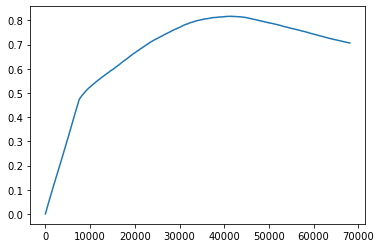

In [21]:
_=build_from_pairs(pairs, valid_df.target.to_list())